# Imports

In [610]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loda import LODA
from pyod.models.iforest import IsolationForest
from pyod.models.abod import ABOD


from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import pdist, squareform

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain, combinations

from collections import Counter

from upsetplot import UpSet, plot, from_memberships

In [209]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# Data

In [266]:
df_train = pd.read_csv("/Users/Giacomo/Desktop/df_train_processed.csv")
df_test = pd.read_csv("/Users/Giacomo/Desktop/df_test_processed.csv")

In [267]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [268]:
print(df_train_num.shape, df_test_num.shape)

(1828, 376) (624, 376)


### Standardization

In [269]:
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [270]:
df_train.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q50,...,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,vocal_channel,emotion,emotional_intensity,statement,repetition,sex
0,0.107840,0.385871,0.435971,0.022102,0.967474,0.036119,0.979319,0.978418,0.998047,0.25,...,0.907952,1.0,0.956060,0.048224,speech,neutral,normal,Kids are talking by the door,1st,M
1,0.117646,0.385792,0.435878,0.023967,0.963262,0.043729,0.977355,0.977549,0.998047,0.25,...,0.885585,1.0,0.107604,0.360443,speech,neutral,normal,Kids are talking by the door,2nd,M
2,0.098033,0.385883,0.435989,0.029249,0.968888,0.054101,0.972723,0.972712,1.000000,0.25,...,0.910557,1.0,0.379996,0.189619,speech,neutral,normal,Dogs are sitting by the door,1st,M
3,0.068626,0.385857,0.435972,0.027946,0.969257,0.058336,0.974555,0.975069,0.998047,0.25,...,0.897600,1.0,0.119724,0.316584,speech,neutral,normal,Dogs are sitting by the door,2nd,M
4,0.176466,0.385852,0.435923,0.015209,0.979741,0.021665,0.985816,0.984619,0.998047,0.25,...,0.888957,1.0,0.201877,0.273444,speech,calm,normal,Kids are talking by the door,1st,M


### One-hot encoding

In [271]:
df_train = pd.get_dummies(df_train)

In [272]:
df_train.shape

(1828, 394)

In [273]:
df_train.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q50,...,emotion_sad,emotion_surprised,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M
0,0.107840,0.385871,0.435971,0.022102,0.967474,0.036119,0.979319,0.978418,0.998047,0.25,...,0,0,1,0,0,1,1,0,0,1
1,0.117646,0.385792,0.435878,0.023967,0.963262,0.043729,0.977355,0.977549,0.998047,0.25,...,0,0,1,0,0,1,0,1,0,1
2,0.098033,0.385883,0.435989,0.029249,0.968888,0.054101,0.972723,0.972712,1.000000,0.25,...,0,0,1,0,1,0,1,0,0,1
3,0.068626,0.385857,0.435972,0.027946,0.969257,0.058336,0.974555,0.975069,0.998047,0.25,...,0,0,1,0,1,0,0,1,0,1
4,0.176466,0.385852,0.435923,0.015209,0.979741,0.021665,0.985816,0.984619,0.998047,0.25,...,0,0,1,0,0,1,1,0,0,1


### Feature reduction

In [274]:
pca = PCA(3)
df_train_pca = pca.fit_transform(df_train)

In [275]:
df_train_pca.shape

(1828, 3)

In [278]:
pd.DataFrame(df_train_pca).head()

,0,1,2
0,-3.023887,0.408420,0.023504
1,-2.889023,-0.117139,0.187455
2,-2.911345,-0.115633,-0.014082
3,-2.908792,0.437646,0.349708
4,-2.687796,0.317941,-0.610201


# Functions

In [279]:
def get_top_scores(decision_scores, percentage, higher_is_outlier=True, show_index=False):
    """Returns the top scores (in the percentage indicated). If show_index = True,
    returns only the correspondent indexes. If higher_is_outlier=False, then lower the score, higher the
    outlierness"""
    n_items = int(np.ceil((percentage * len(decision_scores)) / 100))
    dic = {}
    for index, score in enumerate(decision_scores):
        dic[score] = index
    if higher_is_outlier:
        top_scores = sorted(decision_scores, reverse=True)[:n_items]
    else:
        top_scores = sorted(decision_scores)[:n_items]
    if show_index == True:
        return [dic[score] for score in top_scores]
    return top_scores

In [280]:
def powerset(iterable):
    "Returns the powerset of an iterable"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [281]:
def inter(first, *others):
    "Returns the intersection between more sets"
    return set(first).intersection(*others)

In [629]:
def remove_values(dictionary, threshold):
    """Removes from dictionary all the elements whose values are below
    the given threshold (threshold is included). Returns the new dictionary."""
    new_dict = {}
    for key in dictionary:
        if dictionary[key] >= threshold:
            new_dict[key] = dictionary[key]
    return new_dict

## HBOS

In [282]:
clf = HBOS(contamination=0.01)
clf.fit(df_train)

HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)

In [283]:
outliers = clf.predict(df_train)

In [284]:
indexes_hbos = [index for index, value in enumerate(outliers) if value == 1]

In [285]:
len(indexes_hbos)

19

## EllEnv

### Train

In [286]:
ellenv = EllipticEnvelope(random_state=0, contamination=0.01)
ellenv.fit(df_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


EllipticEnvelope(contamination=0.01, random_state=0)

In [287]:
outliers = ellenv.predict(df_train)

In [288]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  19, 1809]))

In [289]:
indexes_eenv = [index for index, value in enumerate(outliers) if value ==-1]

In [290]:
len(indexes_eenv)

19

## Deviation-Based

In [293]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

In [294]:
scores = {}
for var in df_train:
    for index, value in enumerate(df_train[var]):
        score = sf(value, df_train[var])
        scores[score] = index

In [296]:
top_scores = get_top_scores(list(scores.keys()), 10)[:19]
indexes_dev = [scores[score] for score in top_scores]

In [297]:
len(indexes_dev)

19

## KNN

### Train

In [298]:
clf = KNN(n_neighbors=5)
clf.fit(df_train_pca)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [299]:
scores_knn = get_top_scores(clf.decision_scores_, 1)

In [300]:
indexes_knn = get_top_scores(clf.decision_scores_, 1, show_index=True)

In [301]:
len(indexes_knn)

19

## LOF

### Train

In [302]:
clf = LOF()
clf.fit(df_train_pca)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [303]:
scores_lof = get_top_scores(clf.decision_scores_, 1)

In [304]:
indexes_lof = get_top_scores(clf.decision_scores_, 1, show_index=True)

In [305]:
len(indexes_lof)

19

## DBSCAN

In [306]:
dist = pdist(df_train_pca, 'euclidean')
dist = squareform(dist) 

In [307]:
k=12
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

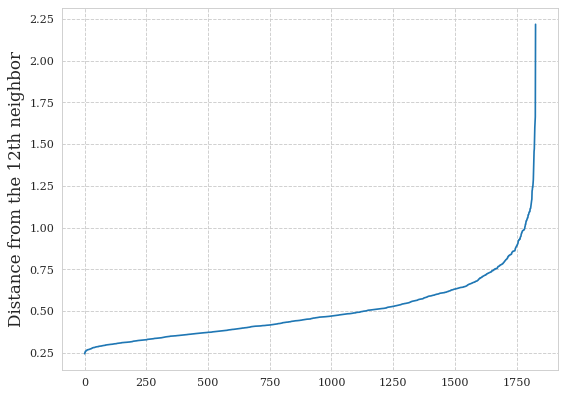

In [308]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('Distance from the {}th neighbor'.format(k))
#pltaxvline()
plt.show() # we plot the distances sorted by distance

In [309]:
dbscan = DBSCAN(eps=0.86, min_samples=12)
dbscan.fit(df_train_pca)

DBSCAN(eps=0.86, min_samples=12)

In [310]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([  19, 1809]))

In [311]:
indexes_dbscan = list(pd.DataFrame(df_train_pca).loc[np.where(dbscan.labels_==-1)].index)

In [312]:
len(indexes_dbscan)

19

## LODA

In [320]:
clf = LODA(contamination=0.01)

In [321]:
clf.fit(df_train)

LODA(contamination=0.01, n_bins=10, n_random_cuts=100)

In [322]:
outliers = clf.predict(df_train)

In [323]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1809,   19]))

In [324]:
indexes_loda = [index for index, value in enumerate(outliers) if value ==1]

In [325]:
len(indexes_loda)

19

# Isolation Forest

In [421]:
clf = IsolationForest(contamination=0.01,random_state=0)
clf.fit(df_train.values)

IsolationForest(contamination=0.01, random_state=0)

In [422]:
outliers = clf.predict(df_train.values)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  19, 1809]))

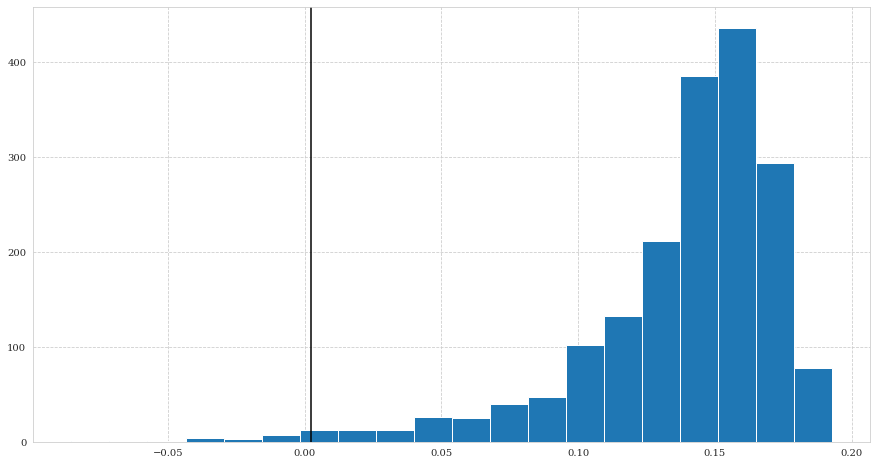

In [423]:
plt.hist(clf.decision_function(df_train.values), bins=20)
plt.axvline(np.min(clf.decision_function(df_train.values)[np.where(outliers==1)]), c='k')
plt.show()

In [424]:
indexes_if = list(np.where(outliers == -1)[0])
len(indexes_if)

19

## ABOD

In [347]:
clf = ABOD()

In [348]:
clf.fit(df_train)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

In [355]:
indexes_abod = get_top_scores(clf.decision_scores_, 1, show_index=True)

In [356]:
len(indexes_abod)

19

# Comparison

In [625]:
index_dict = {"LOF": indexes_lof, 
              "KNN": indexes_knn, 
              "DB": indexes_dev, 
              "HBOS": indexes_hbos,
              "EE": indexes_eenv,
              "DBSCAN": indexes_dbscan,
              "LODA": indexes_loda,
              "IF": indexes_if,
              "ABOD": indexes_abod
             }

In [626]:
print(len(indexes_hbos), len(indexes_dev), 
      len(indexes_lof), len(indexes_knn), 
      len(indexes_eenv), len(indexes_dbscan), 
      len(indexes_loda), len(indexes_if), 
      len(indexes_abod)
     )

19 19 19 19 19 19 19 19 19


In [627]:
sets = powerset([indexes_lof, 
                 indexes_knn, 
                 indexes_dev, 
                 indexes_hbos, 
                 indexes_eenv, 
                 indexes_dbscan,
                 indexes_loda,
                 indexes_if,
                 indexes_abod])
sets = [list(item) for item in sets]
len(sets)

512

In [628]:
intersections = {}
for item in sets:
    if len(item) == 2:
        intersection = inter(item[0], item[1])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key = key1 + "-" + key2
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 3:
        intersection = inter(item[0], item[1], item[2])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key = key1 + "-" + key2 + "-" + key3
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 4:
        intersection = inter(item[0], item[1], item[2], item[3])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 5:
        intersection = inter(item[0], item[1], item[2], item[3], item[4])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 6:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key6 = list(index_dict.keys())[list(index_dict.values()).index(item[5])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5 + "-" + key6
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 7:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key6 = list(index_dict.keys())[list(index_dict.values()).index(item[5])]
        key7 = list(index_dict.keys())[list(index_dict.values()).index(item[6])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5 + "-" + key6 + "-" + key7
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 8:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6], item[7])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key6 = list(index_dict.keys())[list(index_dict.values()).index(item[5])]
        key7 = list(index_dict.keys())[list(index_dict.values()).index(item[6])]
        key8 = list(index_dict.keys())[list(index_dict.values()).index(item[7])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5 + "-" + key6 + "-" + key7 + "-" + key8
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 9:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6], item[7], item[8])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key6 = list(index_dict.keys())[list(index_dict.values()).index(item[5])]
        key7 = list(index_dict.keys())[list(index_dict.values()).index(item[6])]
        key8 = list(index_dict.keys())[list(index_dict.values()).index(item[7])]
        key9 = list(index_dict.keys())[list(index_dict.values()).index(item[8])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5 + "-" + key6 + "-" + key7 + "-" + key8 + "-" + key9
        intersections[key] = round(len(intersection) / len(item[0]), 2)

In [629]:
def remove_values(dictionary, threshold):
    """Removes from dictionary all the elements whose values are below
    the given threshold (threshold is included). Returns the new dictionary."""
    new_dict = {}
    for key in dictionary:
        if dictionary[key] >= threshold:
            new_dict[key] = dictionary[key]
    return new_dict

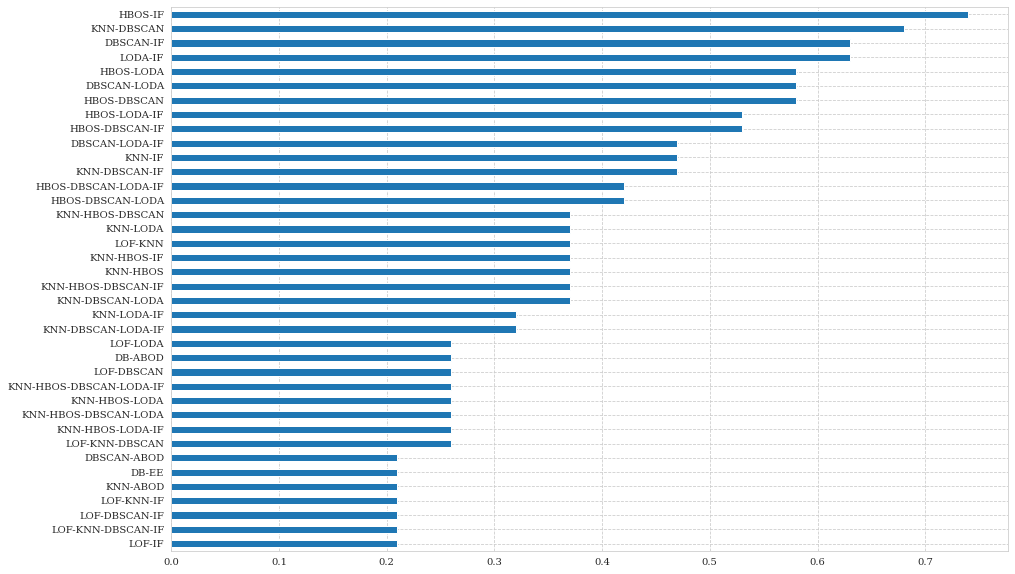

In [630]:
plt.rcParams["figure.figsize"] = (15, 10)
data = pd.DataFrame(remove_values(intersections, 0.2), index=[0]).T.sort_values(by=0)
ax = data.plot(kind="barh")
ax.get_legend().remove()
plt.show()

## Upset Plot

In [611]:
# getting only sets with length > 2
upset_sets = [item for item in sets if len(item) >= 2]    

In [612]:
values = []
for item in upset_sets:
    if len(item) == 2:
        intersection = inter(item[0], item[1])
    elif len(item) == 3:
        intersection = inter(item[0], item[1], item[2])
    elif len(item) == 4:
        intersection = inter(item[0], item[1], item[2], item[3])
    elif len(item) == 5:
        intersection = inter(item[0], item[1], item[2], item[3], item[4])
    elif len(item) == 6:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5])
    elif len(item) == 7:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6])
    elif len(item) == 8:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6], item[7])
    elif len(item) == 9:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5], item[6], item[7], item[8])
    values.append(len(intersection))

In [613]:
labels_sets = []
for item1 in upset_sets:
    new_sets = []
    for item2 in item1:
        key = list(index_dict.keys())[list(index_dict.values()).index(item2)]
        new_sets.append(key)
    labels_sets.append(new_sets)

In [617]:
# dataset to be used for Upset (with absolute values)
dataset_abs = from_memberships(labels_sets, values)
dataset_abs

ABOD   DB     DBSCAN  EE     HBOS   IF     KNN    LODA   LOF  
False  False  False   False  False  False  True   False  True     7
       True   False   False  False  False  False  False  True     2
       False  False   False  True   False  False  False  True     3
                      True   False  False  False  False  True     1
              True    False  False  False  False  False  True     5
                                                                 ..
True   True   True    True   False  True   True   True   True     0
       False  True    True   True   True   True   True   True     0
       True   True    True   True   True   False  True   True     0
                                           True   True   False    0
                                                         True     0
Length: 502, dtype: int64

In [618]:
# dataset to be used for Upset (with percentages)
percentages = [round((value / 19)*100, 2) for value in values]
dataset_perc = from_memberships(labels_sets, percentages)
dataset_perc

ABOD   DB     DBSCAN  EE     HBOS   IF     KNN    LODA   LOF  
False  False  False   False  False  False  True   False  True     36.84
       True   False   False  False  False  False  False  True     10.53
       False  False   False  True   False  False  False  True     15.79
                      True   False  False  False  False  True      5.26
              True    False  False  False  False  False  True     26.32
                                                                  ...  
True   True   True    True   False  True   True   True   True      0.00
       False  True    True   True   True   True   True   True      0.00
       True   True    True   True   True   False  True   True      0.00
                                           True   True   False     0.00
                                                         True      0.00
Length: 502, dtype: float64

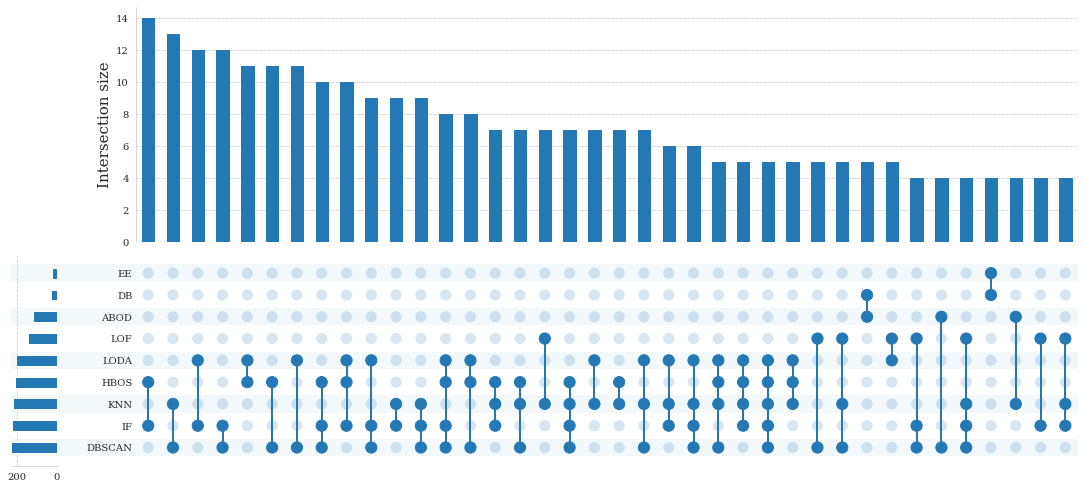

In [666]:
# Upset with absolute values
upset = UpSet(dataset_abs, sort_by="cardinality", min_subset_size=4, facecolor="#2478b4", intersection_plot_elements=10)
upset.plot()
plt.show()

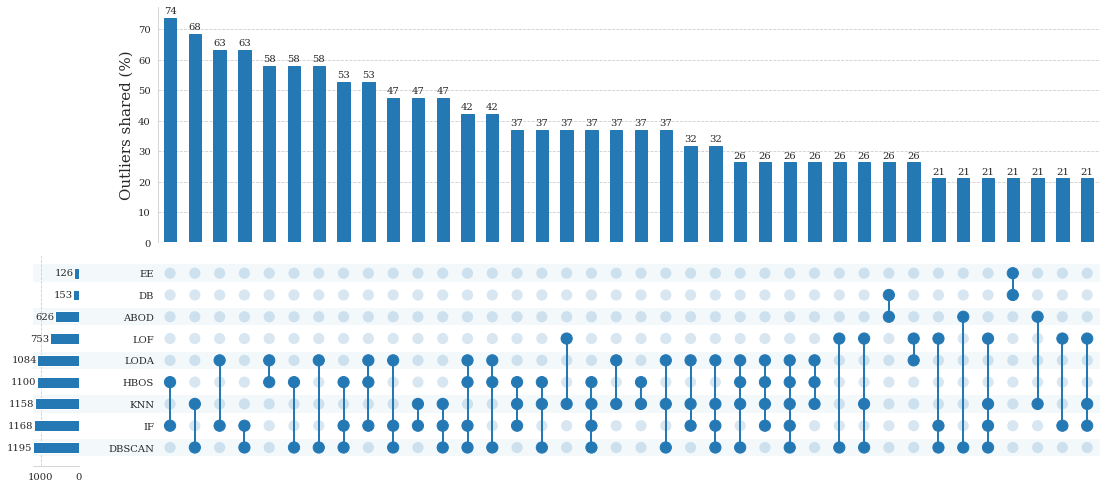

In [683]:
# Upset with percentages
import matplotlib.ticker as mtick
upset = UpSet(dataset_perc, sort_by="cardinality", min_subset_size=20, 
              facecolor="#2478b4", intersection_plot_elements=10, show_counts=True)
upset.plot()
plt.ylabel("Outliers shared (%)")
plt.show()
# here the intersection size is the percentage of shared outliers